In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
train_data = datasets.CIFAR10(
  root="datasets",
  train=True,
  download=True,
  transform=torchvision.transforms.ToTensor(),
  target_transform=None
)
test_data = datasets.CIFAR10(
  root="datasets",
  train=False,
  download=True,
  transform=torchvision.transforms.ToTensor(),
  target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(train_data), len(test_data)

(50000, 10000)

In [4]:
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
train_data.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [5]:
image, label = train_data[0]
label, type(label), classes[label]

(6, int, 'frog')

In [6]:
image.shape

torch.Size([3, 32, 32])

(-0.5, 31.5, 31.5, -0.5)

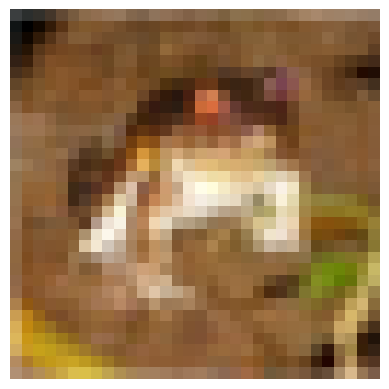

In [7]:
plt.imshow(image.permute(1, 2, 0))
plt.axis(False)

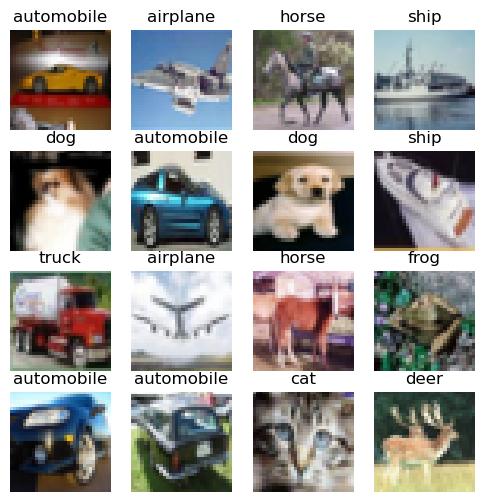

In [8]:
row, col = 4, 4
fig = plt.figure(figsize=(6, 6))
for i in range(1, row*col+1):
  fig.add_subplot(row, col, i)
  image, label = train_data[torch.randint(len(train_data), (1,)).item()]
  plt.imshow(image.permute(1, 2, 0))
  plt.title(classes[label])
  plt.axis(False)

In [3]:
train_labels = [label for _, label in train_data]
test_labels = [label for _, label in test_data]
label_counts_train = Counter(train_labels)
label_counts_test = Counter(test_labels)

In [8]:
classes_train = list(label_counts_train.keys())
counts_train = [label_counts_train[c] for c in classes_train]
classes_test = list(label_counts_test.keys())
counts_test = [label_counts_test[c] for c in classes_test]

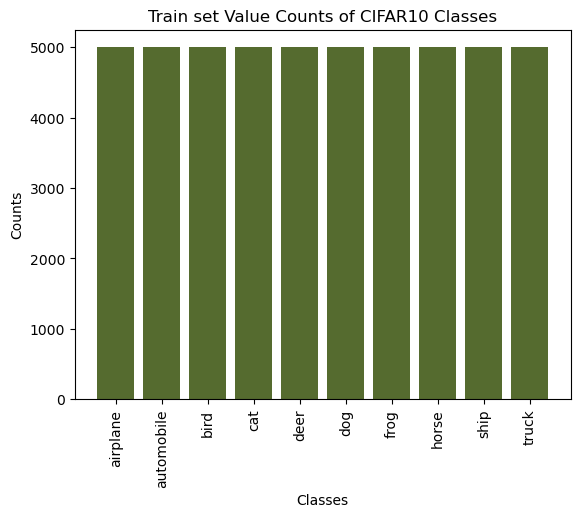

In [13]:
plt.bar(classes_train, counts_train, color="darkolivegreen")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Train set Value Counts of CIFAR10 Classes')
plt.xticks(classes_train, [train_data.classes[c] for c in classes_train], rotation='vertical')
plt.show()

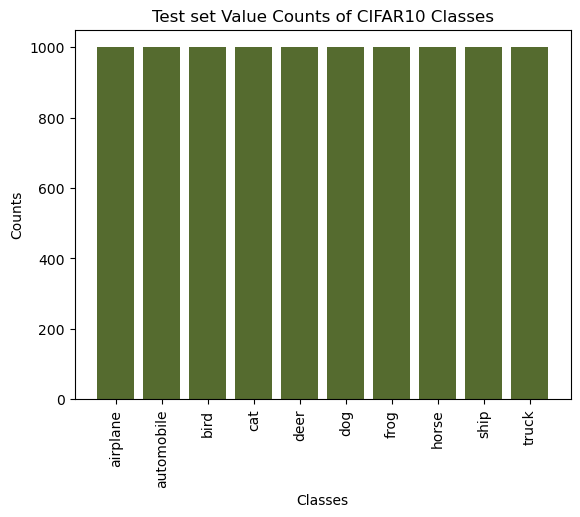

In [14]:
plt.bar(classes_test, counts_test, color="darkolivegreen")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Test set Value Counts of CIFAR10 Classes')
plt.xticks(classes_test, [train_data.classes[c] for c in classes_test], rotation='vertical')
plt.show()

In [9]:
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [10]:
len(train_dataloader), len(test_dataloader)

(1563, 313)

In [11]:
feature_batch, labels_batch = next(iter(train_dataloader))
feature_batch.shape, labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [33]:
class BaseModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(3*32*32, 200),
      nn.Linear(200, len(classes))
    )
    
  def forward(self, x):
    return self.stack(x)
  

base_model = BaseModel()
base_model

BaseModel(
  (stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [16]:
base_model.parameters()

<generator object Module.parameters at 0x7f1ee6c15ee0>

In [17]:
base_model.parameters

<bound method Module.parameters of BaseModel(
  (stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=10, bias=True)
  )
)>

In [18]:
base_model.state_dict

<bound method Module.state_dict of BaseModel(
  (stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=10, bias=True)
  )
)>

In [15]:
base_model.state_dict()

OrderedDict([('stack.1.weight',
              tensor([[-2.5528e-02, -2.7646e-02, -3.3195e-02,  ...,  8.8181e-03,
                       -2.2508e-02,  2.0503e-03],
                      [-9.3124e-03, -1.2579e-02,  2.9252e-02,  ...,  2.9971e-02,
                        1.2737e-02, -1.3999e-02],
                      [ 1.4021e-02, -2.4337e-02, -2.0862e-02,  ...,  2.2076e-02,
                        2.8770e-02,  2.7095e-02],
                      ...,
                      [ 3.6536e-03,  1.6432e-02, -9.3750e-03,  ...,  1.1092e-02,
                       -9.4153e-03,  4.8751e-03],
                      [-2.2310e-02, -1.9990e-02, -1.1759e-02,  ...,  9.3173e-03,
                       -3.2492e-02,  2.5033e-02],
                      [-2.3641e-02,  3.2999e-02,  1.4022e-02,  ...,  2.7411e-02,
                        2.4038e-02,  4.4927e-06]])),
             ('stack.1.bias',
              tensor([ 0.0308,  0.0276, -0.0229,  0.0127, -0.0094, -0.0210,  0.0015, -0.0249,
                       0.021

In [19]:
def acc(y_pred, y_true):
  if len(y_pred) != len(y_true):
    raise "y_pred and y_true have different lengths"
  return torch.eq(y_pred, y_true).sum().item() / len(y_pred)

In [34]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)
# optimizer = torch.optim.AdamW(base_model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(base_model.parameters(), lr=0.01)

In [35]:
base_model.train()
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"epoch {epoch} ---")
  epoch_loss = 0
  
  for i, (image, label) in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):

    logits = base_model(image)

    loss = loss_fn(logits, label)
    # ~softmax already included. softmax of softmax flattens the values
    
    epoch_loss += loss
    if i % 300 == 0:
      print(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  print("---")
  print("epoch loss: ", epoch_loss.item() / len(train_dataloader))
  

base_model.eval();

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 0 ---


  0%|          | 0/1563 [00:00<?, ?it/s]

2.325535297393799
1.9403436183929443
1.6264749765396118
1.8244383335113525
1.9251419305801392
1.9538910388946533
---
epoch loss:  1.9350534391494723
epoch 1 ---


  0%|          | 0/1563 [00:00<?, ?it/s]

1.6155980825424194
1.9392495155334473
1.8968511819839478
1.939159870147705
1.7152713537216187
1.4172738790512085
---
epoch loss:  1.817200214681302
epoch 2 ---


  0%|          | 0/1563 [00:00<?, ?it/s]

1.678227424621582
1.6769020557403564
1.6056090593338013
1.9397053718566895
1.8451058864593506
1.7616302967071533
---
epoch loss:  1.7851460969989603


In [36]:
with torch.inference_mode():
  avg_acc = 0
  avg_loss = 0
  for i, (image, label) in enumerate(tqdm(test_dataloader)):
    logits = base_model(image)
    loss = loss_fn(logits, label)
    accuracy = acc(torch.argmax(logits, dim=1), label)

    avg_loss += loss
    avg_acc += accuracy
    if i % 30 == 0:
      print(f"{i:5} | {accuracy*100:7.2f}% | {loss.item():.5f}")

    
  print(avg_acc / len(test_dataloader)*100, avg_loss.item() / len(test_dataloader))

  0%|          | 0/313 [00:00<?, ?it/s]

    0 |   43.75% | 1.54120
   30 |   34.38% | 1.76665
   60 |   40.62% | 2.06507
   90 |   37.50% | 2.14434
  120 |   37.50% | 1.72445
  150 |   28.12% | 1.74647
  180 |   53.12% | 1.57862
  210 |   31.25% | 1.72472
  240 |   59.38% | 1.30933
  270 |   28.12% | 1.91049
  300 |   37.50% | 1.76849
33.97563897763578 1.8668772542057708


In [43]:
class ModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(3*32*32, 150),
      nn.Tanh(),
      nn.Linear(150, 80),
      nn.Tanh(),
      nn.Linear(80, len(classes)),
    )
    
  def forward(self, x):
    return self.stack(x)
  

modelV1 = ModelV1().to(device)
modelV1, next(modelV1.parameters()).device

(ModelV1(
   (stack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=3072, out_features=150, bias=True)
     (2): Tanh()
     (3): Linear(in_features=150, out_features=80, bias=True)
     (4): Tanh()
     (5): Linear(in_features=80, out_features=10, bias=True)
   )
 ),
 device(type='cpu'))

In [44]:
model = modelV1

In [45]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [46]:
model.train()
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"epoch {epoch} ---")
  epoch_loss = 0
  
  for i, (image, label) in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):

    logits = model(image)

    loss = loss_fn(logits, label)
    # ~softmax already included. softmax of softmax flattens the values
    
    epoch_loss += loss
    if i % 300 == 0:
      print(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  print("---")
  print("epoch loss: ", epoch_loss.item() / len(train_dataloader))
  

model.eval();

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 0 ---


  0%|          | 0/1563 [00:00<?, ?it/s]

2.2953128814697266
2.272106409072876
2.0684099197387695
1.8699913024902344
2.061988115310669
1.8213094472885132
---
epoch loss:  2.000742418676024
epoch 1 ---


  0%|          | 0/1563 [00:00<?, ?it/s]

1.9009102582931519
2.0617125034332275
2.122981071472168
1.9965261220932007
1.8631322383880615
1.831447720527649
---
epoch loss:  1.9173024007317658
epoch 2 ---


  0%|          | 0/1563 [00:00<?, ?it/s]

1.9265940189361572
1.7385430335998535
1.7803850173950195
2.0211920738220215
2.147132158279419
1.8772473335266113
---
epoch loss:  1.8810191676163628


In [47]:
with torch.inference_mode():
  avg_acc = 0
  avg_loss = 0
  for i, (image, label) in enumerate(tqdm(test_dataloader)):
    logits = model(image)
    loss = loss_fn(logits, label)
    accuracy = acc(torch.argmax(logits, dim=1), label)

    avg_loss += loss
    avg_acc += accuracy
    if i % 30 == 0:
      print(f"{i:5} | {accuracy*100:7.2f}% | {loss.item():.5f}")

    
  print(avg_acc / len(test_dataloader)*100, avg_loss.item() / len(test_dataloader))

  0%|          | 0/313 [00:00<?, ?it/s]

    0 |   43.75% | 1.67397
   30 |   37.50% | 1.77902
   60 |   25.00% | 1.98991
   90 |   28.12% | 1.84365
  120 |   34.38% | 1.92583
  150 |   40.62% | 1.84028
  180 |   43.75% | 1.47787
  210 |   46.88% | 1.65272
  240 |   53.12% | 1.48453
  270 |   37.50% | 1.81765
  300 |   50.00% | 1.66728
33.97563897763578 1.8411223682732627
